In [2]:
from google.colab import files
files.upload()   # yahan pe ap kaggle.json upload karoge


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"waleedkhanafridi","key":"0c99ac23d87927168abb7a24864a755a"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [4]:
!kaggle datasets download -d lucassj/dogs-vs-cats-train-validadion-and-evaluation
!unzip dogs-vs-cats-train-validadion-and-evaluation.zip -d data


Streaming output truncated to the last 5000 lines.
  inflating: data/validation/cat/cat.10000.jpg  
  inflating: data/validation/cat/cat.10001.jpg  
  inflating: data/validation/cat/cat.10002.jpg  
  inflating: data/validation/cat/cat.10003.jpg  
  inflating: data/validation/cat/cat.10004.jpg  
  inflating: data/validation/cat/cat.10005.jpg  
  inflating: data/validation/cat/cat.10006.jpg  
  inflating: data/validation/cat/cat.10007.jpg  
  inflating: data/validation/cat/cat.10008.jpg  
  inflating: data/validation/cat/cat.10009.jpg  
  inflating: data/validation/cat/cat.10010.jpg  
  inflating: data/validation/cat/cat.10011.jpg  
  inflating: data/validation/cat/cat.10012.jpg  
  inflating: data/validation/cat/cat.10013.jpg  
  inflating: data/validation/cat/cat.10014.jpg  
  inflating: data/validation/cat/cat.10015.jpg  
  inflating: data/validation/cat/cat.10016.jpg  
  inflating: data/validation/cat/cat.10017.jpg  
  inflating: data/validation/cat/cat.10018.jpg  
  inflating: data/

In [5]:
from tensorflow import keras
from keras.layers import Dense, Flatten
from keras.applications import ResNet50
from keras.models import Model

#  Data Preprocessing

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

traingen=ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    height_shift_range=0.1,
    width_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

val_gen=ImageDataGenerator(rescale=1./255)

train_ds=traingen.flow_from_directory(
    '/content/data/train',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
)

val_ds=val_gen.flow_from_directory(
    '/content/data/validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
)


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


# Base Model (Transfer Learning)

In [7]:
base_model=ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [19]:
for layer in base_model.layers[-30:]:
    layer.trainable=True


# Model Architecture

In [20]:
model = keras.models.Sequential([
    base_model,
    keras.layers.GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),
    Dense(128, activation='relu'),
    keras.layers.Dropout(0.3),
    Dense(1, activation='sigmoid')
])


# model summary

In [21]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,281 (92.11 MB)

 Trainable params: 24,092,161 (91.90 MB)

 Non-trainable params: 53,120 (207.50 KB)

# Compile Model

In [22]:
model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

#  Callbacks

In [23]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks=[
    EarlyStopping(patience=3, restore_best_weights=True),
    ReduceLROnPlateau(factor=0.2, patience=2,min_lr=1e-7 )
]

# Training (Warmup Phase)

In [24]:
history=model.fit(train_ds , epochs=5, validation_data=val_ds, callbacks=callbacks)

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 366s 494ms/step - accuracy: 0.8427 - loss: 0.3341 - val_accuracy: 0.7960 - val_loss: 0.4341 - learning_rate: 1.0000e-05
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 352s 490ms/step - accuracy: 0.9833 - loss: 0.0503 - val_accuracy: 0.9864 - val_loss: 0.0380 - learning_rate: 1.0000e-05
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 304s 486ms/step - accuracy: 0.9869 - loss: 0.0361 - val_accuracy: 0.9882 - val_loss: 0.0376 - learning_rate: 1.0000e-05
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 304s 486ms/step - accuracy: 0.9895 - loss: 0.0294 - val_accuracy: 0.9862 - val_loss: 0.0396 - learning_rate: 1.0000e-05
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 303s 484ms/step - accuracy: 0.9915 - loss: 0.0220 - val_accuracy: 0.9872 - val_loss: 0.0418 - learning_rate: 1.0000e-05


# Cofusion Martrix

Found 5000 images belonging to 2 classes.
157/157 ━━━━━━━━━━━━━━━━━━━━ 21s 106ms/step


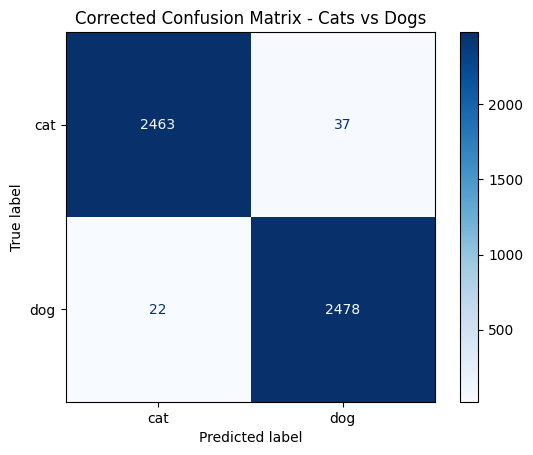

In [25]:
# Reload validation generator with shuffle=False
val_ds = val_gen.flow_from_directory(
    '/content/data/validation',
    target_size=(224,224),
    batch_size=32,
    class_mode='binary',
    shuffle=False   # FIX
)

# Predictions
y_pred = model.predict(val_ds)
y_pred_classes = (y_pred > 0.5).astype("int32")
y_true = val_ds.classes

# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=val_ds.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title("Corrected Confusion Matrix - Cats vs Dogs")
plt.show()
